# Analyzing m6A patterns in multiple methods (CPU-based)

---

Author: Jianheng Liu @ Rui Zhang's Lab, SYSU, China

Email: jhfoxliu@gmail.com

Date: Jan, 2022

## Packages

- Python==3.7.8
- numpy==1.20.0
- scipy==1.5.1
- umap-learn==0.5.2
- sklearn==0.23.1
- matplotlib==3.2.2
- seaborn==0.10.1
- hdbscan==0.8.27

## 0.1 Configure the environment

In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan

# for Linux only, load font file
mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

tracemalloc.start()

## 0.2 Define functions

In [2]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [3]:
def cluster_HDBSCAN_softclustering(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [4]:
def subcluster_HDBSCAN_softclustering(df, target=None, cluster_col="Cluster", min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, alpha=1., cluster_selection_method='leaf', draw_condensed_tree=True):
    # use multi-code here
    df = df.copy()
    max_cluster_id = df[cluster_col].max()
    
    df1 = df[df[cluster_col]==target].copy()
    
    X = np.stack([df1["X"], df1["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=50, cluster_selection_method=cluster_selection_method, alpha=1., core_dist_n_jobs=4, prediction_data=True)
    yhat = model.fit(X)
    
    soft_clusters = hdbscan.all_points_membership_vectors(yhat)
    labels = [np.argmax(x) for x in soft_clusters] 
    # labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df1[cluster_col] = [max_cluster_id + i + 1 for i in labels ]  # re-number lables to make it human-readable
    df.loc[df1.index, cluster_col] = df1[cluster_col].tolist()
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    # print("==================================================")
    # check cluster number
    print(df.groupby(cluster_col)[cluster_col].count())
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model

In [5]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=0.2, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax 

In [6]:
def draw_methods(ax, df, target=None, common_contour_xx=None, common_contour_yy=None, common_contour_f=None, title=None, save_contour_diameter=10, xmin=None, xmax=None, ymin=None, ymax=None, s=0.2, alpha=0.2):
    clusters = list([i for i in range(1, int(df["Cluster"].max())+1)]) + [-1]
    
    if type(target) == list:
        df = df.loc[df[target].any(axis=1) == True].copy()
    elif type(target) == str:
        df = df.loc[df[target] == True].copy()
    
    indexes = []
    print("Drawing {}".format(target))
    for i in clusters:
        if i is None or i == -1:
            continue
        else:
            subdf = df.loc[df["Cluster"]==i]
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13
            indexes.extend(subdf.index.tolist())
    df = df.loc[indexes].copy() 
    
    if xmin is None or xmax is None or ymin is None or ymax is None:
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()


    # draw density
    if common_contour_xx is not None and common_contour_yy is not None and common_contour_f is not None:
        c = ax.contour(common_contour_xx, common_contour_yy, common_contour_f, linewidths=0.5, linestyles="--",  colors="gray")
       
        for level in c.collections:
            for kp,path in reversed(list(enumerate(level.get_paths()))):
                verts = path.vertices # (N,2)-shape array of contour line coordinates
                diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
                if diameter<save_contour_diameter: # threshold to be refined for your actual dimensions!
                    del(level.get_paths()[kp])  # no remove() for Path objects:(
        
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5,colors="k")
    
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)

In [7]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column].replace("T", "U")))  # to RNA bases
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A rna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A rna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A rna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i -10 -P cluster_{g} -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A rna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i -10 -f ./{prefix}/fasta/cluster_{g}.fa > ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [8]:
def show_logos(prefix, names=None):
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        plt.figure()
        image = plt.imread(prefix+"/"+img)
        plt.imshow(image)
        plt.axis("off")

In [9]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        id = int(i.replace("cluster_", "").replace(".png", ""))
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, image in zip(*[axes.reshape(-1), file_list_format]):
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = ax.imshow(img)
        ax.set_title("cluster_{}".format(id))
    for ax in axes.reshape(-1):
        ax.axis("off")
    plt.tight_layout()

In [10]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCGN"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

## 1. Load data from fasta files

Note that the source fasta files are in different corrdinates, we should make it all in hg38:

m6ACE-seq ... GRCh38 (Ensembl style)

m6A-label-seq ... GRCh38 (Ensembl sytle) ← Retrived from RefSeq ids, not 100% cover original study. (9360/14439 sites from HEK293T, 3227/4974 sites from HeLa)

CITS/CIMS ... hg38 (UCSC style) ← We convert UCSC chr names to Ensembl

m6A-REF-seq ... hg19 (UCSC style) ← We firstly liftover it to hg38, then convert UCSC chr names to Ensembl



We use the table from NCBI (https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.39,GCF_000001405.39/?utm_source=gquery) to align the chromosome names.

In [11]:
def load_chr_name_table(fn):
    UCSC_to_Ensembl = {}
    df_chr_names = pd.read_table(fn, index_col=None, header=0)
    primary_asseblies = df_chr_names[df_chr_names["Sequence-Role"] == "assembled-molecule"]
    contigs = df_chr_names[df_chr_names["Sequence-Role"] != "assembled-molecule"]
    for idx, row in primary_asseblies.iterrows():
        UCSC_to_Ensembl[row["UCSC-style-name"]] = row["Sequence-Name"]
    for idx, row in contigs.iterrows():
        UCSC_to_Ensembl[row["UCSC-style-name"]] = row["GenBank-Accn"]
    
    # To show the conversion
    #for key, value in UCSC_to_Ensembl.items():
    #   print("{}\t{}".format(key, value))
    return UCSC_to_Ensembl

UCSC_to_Ensembl = load_chr_name_table("chr.names.txt")

### Formally load data into a CSV table

In [12]:
all_sequences = {}
dfs = []
def load_sequences_from_fasta(fn, sample_name, convert_to_ensembl=False):
    from Bio import SeqIO
    
    global dfs
    indexes = []
    for seq in SeqIO.parse(fn, "fasta"):
        chr, pos, strand = seq.id.split("|")
        if convert_to_ensembl == True:
            chr = UCSC_to_Ensembl[chr]
        ID = "{}@{}@{}".format(chr, pos, strand)
        seq = str(seq.seq).upper()
        if seq is None or len(seq) != 21 or seq[10] != "A":  # skip non-A sequences
            continue
        all_sequences[ID] = seq
        indexes.append(ID)
        
    subdf = pd.DataFrame(index=indexes, columns=[sample_name])
    subdf = subdf[~subdf.index.duplicated(keep='first')]
    subdf[sample_name] = True
    dfs.append(subdf)

# Data from CIMS/CITS (doi:10.1038/nmeth.3453), HEK293
load_sequences_from_fasta("GSE63753_hek293.sysy.CITS.m6A.12051.hg38.F10.fa", "CITS", convert_to_ensembl=True)
load_sequences_from_fasta("GSE63753_hek293.abcam.CIMS.m6A.9536.hg38.F10.fa", "CIMS", convert_to_ensembl=True)

# Data from m6ACE-seq(doi:0.1038/s41467-019-13561-z), HEK293T
load_sequences_from_fasta("m6ACE_seq_METTL3_KO_1.F10.fa", "m6ACE-seq_METTL3")
load_sequences_from_fasta("m6ACE_seq_METTL16.F10.fa", "m6ACE-seq_METTL16")
load_sequences_from_fasta("m6ACE_seq_PCIF1.F10.fa", "m6ACE-seq_PCIF1")
load_sequences_from_fasta("m6ACE_seq_FTO_regulated.F10.fa", "m6ACE-seq_FTO_reg")
load_sequences_from_fasta("m6ACE_seq_FTO_OE.F10.fa", "m6ACE-seq_FTO_OE")
load_sequences_from_fasta("m6ACE_seq_ALKBH5_regulated.F10.fa", "m6ACE-seq_ALKBH5")

# Data from m6A-label-seq(doi.org:10.1038/s41589-020-0526-9), HEK293T + HeLa
load_sequences_from_fasta("293T_HeLa.allyl.F10.fa", "m6A-label-seq")

# Data from m6A-REF-seq (doi:10.1126/sciadv.aax0250), HEK293T
load_sequences_from_fasta("m6A_REF_seq.hg38.F10.fa", "m6A-REF-seq", convert_to_ensembl=True)

# Data from MAZTER-seq (doi.org/10.1016/j.cell.2019.06.013), HEK293T + hESC
load_sequences_from_fasta("MAZTER-seq.293T.hESC.high_highest.hg38.F10.fa", "MAZTER-seq_high", convert_to_ensembl=True)
load_sequences_from_fasta("MAZTER-seq.293T.hESC.intermediate.hg38.F10.fa", "MAZTER-seq_intermediate", convert_to_ensembl=True)
load_sequences_from_fasta("MAZTER-seq.293T.hESC.low.hg38.F10.fa", "MAZTER-seq_low", convert_to_ensembl=True)

df_m6A = pd.concat(dfs, axis=1)
df_m6A.fillna(False, inplace=True)
df_m6A["motif_F10"] = df_m6A.apply(lambda x: all_sequences.get(x.name), axis=1)

print(df_m6A)

              CITS   CIMS  m6ACE-seq_METTL3  m6ACE-seq_METTL16  \
1@633671@+    True  False             False              False   
1@925104@+    True  False             False              False   
1@929692@+    True  False             False              False   
1@942771@+    True   True              True              False   
1@942897@+    True  False              True              False   
...            ...    ...               ...                ...   
Y@2865155@+  False  False             False              False   
Y@2961380@+  False  False             False              False   
Y@2961411@+  False  False             False              False   
Y@2979654@+  False  False             False              False   
Y@7379329@+  False  False             False              False   

             m6ACE-seq_PCIF1  m6ACE-seq_FTO_reg  m6ACE-seq_FTO_OE  \
1@633671@+             False              False             False   
1@925104@+             False              False             False   


In [13]:
onehot_input_m6A = []
for idx, row in df_m6A.iterrows():
    onehot_input_m6A.append(onehot_enc(row))
onehot_input_m6A = np.array(onehot_input_m6A)

## 2. UMAP and HBSCAN

In [14]:
_, _, df_m6A = UMAP(onehot_input_m6A, df_m6A, verbose=True)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Sun Feb 13 01:20:55 2022 Construct fuzzy simplicial set
Sun Feb 13 01:20:55 2022 Finding Nearest Neighbors
Sun Feb 13 01:20:55 2022 Building RP forest with 18 trees
Sun Feb 13 01:21:01 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Sun Feb 13 01:24:28 2022 Finished Nearest Neighbor Search
Sun Feb 13 01:24:32 2022 Construct embedding



Sun Feb 13 01:25:53 2022 Finished embedding
UMAP time: 297.8473057746887 sec
UMAP RAM: 350.6771068572998 MB



HDBSCAN soft clustering time: 10.923757553100586 sec
HDBSCAN soft clustering RAM: 317.7006435394287 Mb
HDBSCAN cluster number: 4
Cluster
1     1601
2    54738
3     2556
4     7619
Name: Cluster, dtype: int64


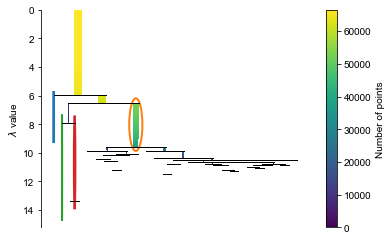

In [15]:
_, _, df_m6A, _= cluster_HDBSCAN_softclustering(df_m6A, min_cluster_size=100, min_samples=100, cluster_selection_epsilon=0.0)

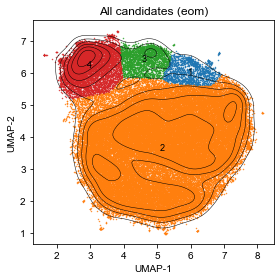

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_m6A, title="All candidates (eom)")
plt.tight_layout()
plt.savefig("m6A_all.eom.png", dpi=300)

Seems we need to handle some hard clusters in cluster #2

## 2.1 Further split cluster #2 by leaf

HDBSCAN soft clustering time: 22.89223313331604 sec
HDBSCAN soft clustering RAM: 259.14994049072266 Mb
HDBSCAN cluster number: 82
Cluster
1     1601
3     2556
4     7619
5      361
6      565
      ... 
78     473
79     732
80     622
81     435
82     893
Name: Cluster, Length: 81, dtype: int64


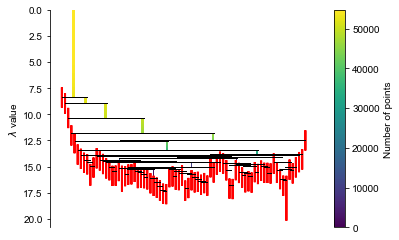

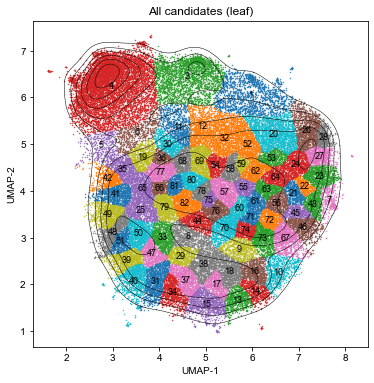

In [17]:
# because cluster #2 is large, use large parameters to avoid small clusters
_, _, df_m6A, _ = subcluster_HDBSCAN_softclustering(df_m6A, target=2, min_cluster_size=100, min_samples=100, alpha=1., cluster_col="Cluster", cluster_selection_epsilon=0., cluster_selection_method="leaf")
fig, ax = plt.subplots(figsize=(6,6))
_, _, _, _ = draw_one_sample(ax, df_m6A, title="All candidates (leaf)")

The problem is, there are too many clustersf for us to gather them one-by-one. We should make it more efficient.

It obviously that the big cluster can be split into two parts by the mass of the points. We can utlize it.

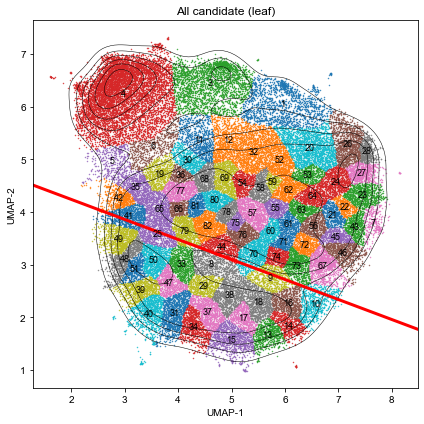

In [18]:
fig, ax = plt.subplots(figsize=(6,6))
_, _, _, _ = draw_one_sample(ax, df_m6A, title="All candidate (leaf)")
Xs = np.linspace(xmin, xmax, num=100)
Ys = -0.38*Xs+5.
_ = ax.plot(Xs, Ys, lw=3, c="r")
plt.tight_layout()
plt.savefig("m6A_all.leaf.png", dpi=300)

Cluster
1     1601
2    19029
3     2556
4     7619
5      926
6    32394
7     2389
Name: Cluster, dtype: int64


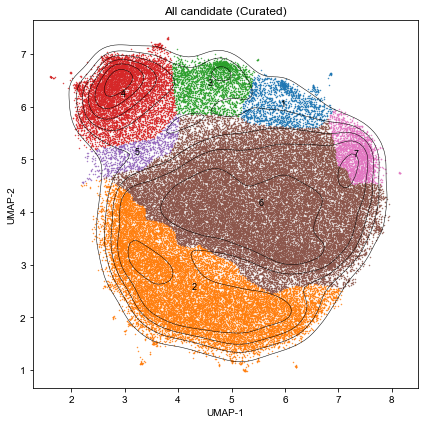

In [19]:
def helper_split_cluster(df, min_cluster_id=1):
    clusters = list([i for i in range(min_cluster_id, int(df["Cluster"].max())+1)])
    indexes = []
    new_clusters = []
    for i in clusters:
        subdf = df[df["Cluster"]==i].copy()
        X_cluster = subdf["X"].mean()
        Y_cluster = subdf["Y"].mean()
        if i in [41, 42, 25, 10, 8]:
            indexes.extend(subdf.index.tolist())
            new_clusters.extend([2] * subdf.shape[0])
        elif i in [5, 6]:
            indexes.extend(subdf.index.tolist())
            new_clusters.extend([5] * subdf.shape[0])
        elif i in [26, 28, 27]:
            indexes.extend(subdf.index.tolist())
            new_clusters.extend([7] * subdf.shape[0])
        elif -0.38*X_cluster+4.7 > Y_cluster:
            indexes.extend(subdf.index.tolist())
            new_clusters.extend([2] * subdf.shape[0])
        else:
            indexes.extend(subdf.index.tolist())
            new_clusters.extend([6] * subdf.shape[0])
    del subdf
    return indexes, new_clusters
indexes, new_clusters = helper_split_cluster(df_m6A, min_cluster_id=5)
df_m6A_2 = df_m6A.copy()
df_m6A_2.loc[indexes, "Cluster"] = new_clusters
print(df_m6A_2.groupby("Cluster")["Cluster"].count())
fig, ax = plt.subplots(figsize=(6,6))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_m6A_2, title="All candidate (Curated)")
plt.tight_layout()
plt.savefig("m6A_all.curated.png", dpi=300)
plt.savefig("m6A_all.curated.pdf")

In [20]:
# reset cluster id
cluster_transform = {2:1, 6:2, 7:3, 4:4, 5:7, 3:5, 1:6}
df_m6A_2["Cluster"] = df_m6A_2.apply(lambda x: cluster_transform.get(x["Cluster"]), axis=1)
print(df_m6A_2.groupby("Cluster")["Cluster"].count())
df_m6A_2 = df_m6A_2.sort_values(by="Cluster")

Cluster
1    19029
2    32394
3     2389
4     7619
5     2556
6     1601
7      926
Name: Cluster, dtype: int64


Sadly, we need some patience to do so and this strategy might not work when the shape of the cluster is complicated.

In [21]:
# Check what's inside
extract_fasta_and_draw_motifs("m6A_methods", df_m6A_2)

===============  m6A_methods ===============
Cluster #1: 19029
Cluster #2: 32394
Cluster #3: 2389
Cluster #4: 7619
Cluster #5: 2556
Cluster #6: 1601
Cluster #7: 926


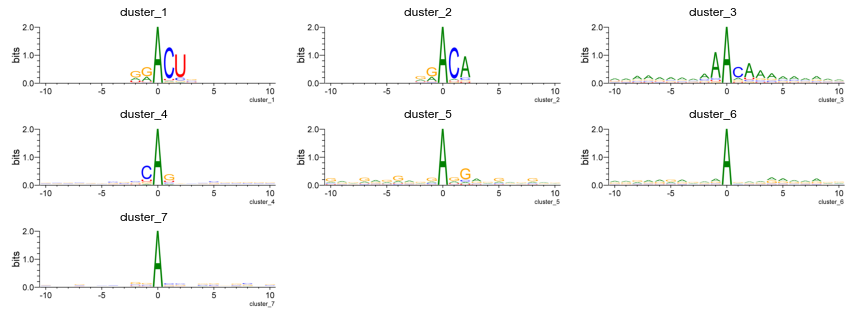

In [22]:
show_logos_cols("./m6A_methods/logos_bits_png/", cols=3)

Seems that:

Cluster #1: noise without specific pattern

Cluster #2: canonical RRACH motif for m6A (RRACU)

Cluster #3: unknown one with a G enrichment at +2 positin

Cluster #4: canonical CAG motif for m6Am

Cluster #5: noise without specific pattern

Cluster #6: canonical RRACH motif for m6A (RRACA)



## 4.3 Label methods

You must be curious enough to investigate which method contribute to which type of cluster most. Let's begin.

In [23]:
df_m6A = df_m6A_2

In [24]:
common_contour_xx, common_contour_yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([common_contour_xx.ravel(), common_contour_yy.ravel()])
values = np.vstack([df_m6A["X"], df_m6A["Y"]])
kernel = scipy.stats.gaussian_kde(values)
common_contour_f = np.reshape(kernel(positions).T, common_contour_xx.shape)

### 4.3.1 Draw scatters

Drawing CIMS
Drawing CITS
Drawing ['m6ACE-seq_METTL3', 'm6ACE-seq_METTL16', 'm6ACE-seq_PCIF1', 'm6ACE-seq_FTO_reg', 'm6ACE-seq_FTO_OE', 'm6ACE-seq_ALKBH5']
Drawing m6A-label-seq
Drawing m6A-REF-seq
Drawing ['MAZTER-seq_high', 'MAZTER-seq_intermediate', 'MAZTER-seq_low']


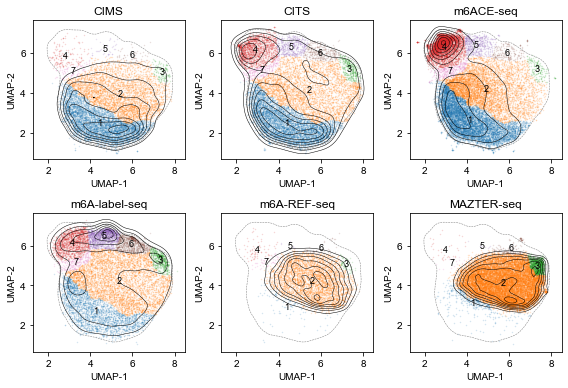

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5))

m6ACE_seq_samples = ["m6ACE-seq_METTL3", "m6ACE-seq_METTL16", "m6ACE-seq_PCIF1", "m6ACE-seq_FTO_reg", "m6ACE-seq_FTO_OE", "m6ACE-seq_ALKBH5"]
MAZTER_seq_samples = ["MAZTER-seq_high", "MAZTER-seq_intermediate", "MAZTER-seq_low"]

sample_titles = ["CIMS", "CITS", "m6ACE-seq", "m6A-label-seq", "m6A-REF-seq", "MAZTER-seq"]
sample_names = ["CIMS", "CITS", m6ACE_seq_samples, "m6A-label-seq", "m6A-REF-seq", MAZTER_seq_samples]

# note: adjsut save_contour_diameter to keep the outest contour
for ax, title, samples in zip(*[axes.reshape(-1), sample_titles, sample_names]):
    draw_methods(ax, df_m6A, save_contour_diameter=5.8, title=title, target=samples, common_contour_xx=common_contour_xx, common_contour_yy=common_contour_yy, common_contour_f=common_contour_f, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
plt.tight_layout()
plt.savefig("Scatter_Methods.pdf")

### 4.3.2 Draw percentages

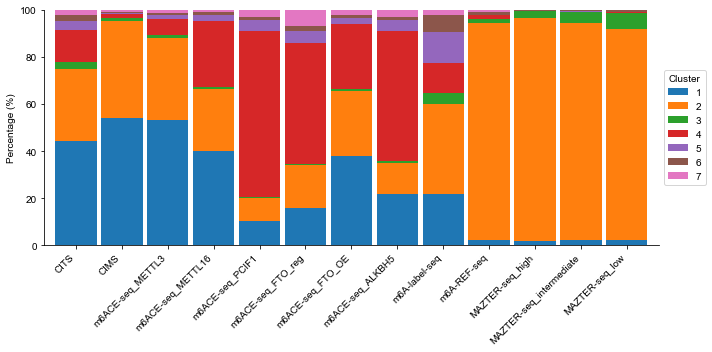

In [26]:
def draw_cluster_trace(ax, df, title=None):
    df_analysis = df[[i for i in df.columns if i not in ["X", "Y", "Cluster", "Group"] ]].copy()
    df_analysis["Cluster"] = df["Cluster"]

    df_groupby = df_analysis.groupby("Cluster").sum()
    df_groupby.to_csv(title.replace(".","_")+".count.csv")
    
    df_groupby = df_groupby/(df_groupby.sum(axis=0) + 0.) * 100.

    df_groupby = df_groupby.T
    df_groupby.plot(kind="bar", stacked=True, ax=ax, width=0.9)
    ax.set_ylabel("Percentage (%)")
    ax.set_ylim(0, 100)
    sns.despine()
    # ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.0, 0.5), title="Cluster", loc='center left')
    df_groupby.to_csv(title.replace(".","_")+".percent.csv")
    
fig, ax = plt.subplots(figsize=(10,5))
draw_cluster_trace(ax, df_m6A, "Cluster")
plt.tight_layout()
plt.savefig("Clusters_percentage.pdf")

In [27]:
extract_fasta_and_draw_motifs("CITS", df_m6A, cluster_col="Cluster", filter="CITS", draw_logos=True)

===============  CITS ===============
Cluster #1: 5319
Cluster #2: 3727
Cluster #3: 354
Cluster #4: 1645
Cluster #5: 452
Cluster #6: 312
Cluster #7: 240


In [28]:
extract_fasta_and_draw_motifs("CIMS", df_m6A, cluster_col="Cluster", filter="CIMS", draw_logos=True)

===============  CIMS ===============
Cluster #1: 5142
Cluster #2: 3926
Cluster #3: 133
Cluster #4: 160
Cluster #5: 39
Cluster #6: 52
Cluster #7: 84


In [29]:
extract_fasta_and_draw_motifs("m6ACE-seq_all", df_m6A[df_m6A[m6ACE_seq_samples].sum(axis=1)>=1], cluster_col="Cluster", draw_logos=True)

===============  m6ACE-seq_all ===============
Cluster #1: 8406
Cluster #2: 5643
Cluster #3: 164
Cluster #4: 4458
Cluster #5: 504
Cluster #6: 199
Cluster #7: 328


In [30]:
for i in m6ACE_seq_samples:
    extract_fasta_and_draw_motifs("m6ACE-seq_{}".format(i), df_m6A, filter=i, cluster_col="Cluster", draw_logos=True)

===============  m6ACE-seq_m6ACE-seq_METTL3 ===============
Cluster #1: 7834
Cluster #2: 5121
Cluster #3: 153
Cluster #4: 1034
Cluster #5: 264
Cluster #6: 129
Cluster #7: 164
===============  m6ACE-seq_m6ACE-seq_METTL16 ===============
Cluster #1: 241
Cluster #2: 157
Cluster #3: 4
Cluster #4: 167
Cluster #5: 15
Cluster #6: 8
Cluster #7: 6
===============  m6ACE-seq_m6ACE-seq_PCIF1 ===============
Cluster #1: 433
Cluster #2: 417
Cluster #3: 10
Cluster #4: 2964
Cluster #5: 203
Cluster #6: 52
Cluster #7: 129
===============  m6ACE-seq_m6ACE-seq_FTO_reg ===============
Cluster #1: 40
Cluster #2: 46
Cluster #3: 1
Cluster #4: 130
Cluster #5: 13
Cluster #6: 6
Cluster #7: 17
===============  m6ACE-seq_m6ACE-seq_FTO_OE ===============
Cluster #1: 137
Cluster #2: 101
Cluster #3: 3
Cluster #4: 100
Cluster #5: 9
Cluster #6: 4
Cluster #7: 8
===============  m6ACE-seq_m6ACE-seq_ALKBH5 ===============
Cluster #1: 145
Cluster #2: 90
Cluster #3: 4
Cluster #4: 371
Cluster #5: 29
Cluster #6: 9
Cluster #7

In [31]:
extract_fasta_and_draw_motifs("m6A-label-seq", df_m6A, filter="m6A-label-seq", cluster_col="Cluster", draw_logos=True)

===============  m6A-label-seq ===============
Cluster #1: 2609
Cluster #2: 4598
Cluster #3: 568
Cluster #4: 1509
Cluster #5: 1579
Cluster #6: 902
Cluster #7: 247


In [32]:
extract_fasta_and_draw_motifs("MAZTER-seq", df_m6A[df_m6A[MAZTER_seq_samples].sum(axis=1)>=1], cluster_col="Cluster", draw_logos=True)

===============  MAZTER-seq ===============
Cluster #1: 421
Cluster #2: 17575
Cluster #3: 1210
Cluster #4: 34
Cluster #5: 9
Cluster #6: 141
Cluster #7: 14


In [33]:
extract_fasta_and_draw_motifs("m6A-REF-seq", df_m6A, filter="m6A-REF-seq", cluster_col="Cluster", draw_logos=True)

===============  m6A-REF-seq ===============
Cluster #1: 93
Cluster #2: 3933
Cluster #3: 61
Cluster #4: 75
Cluster #5: 8
Cluster #6: 44
Cluster #7: 46


### Summary

1. Certainly, enzymetic methods (m6A-REF-seq and MAZTER-seq) devotedly generated a set of sites suffix with a "ACA" motif and antibody caused reverse transcription error based method CIMS also have a preference of a +1 C.
2. The GAC motif of m6Am (cluster #4) can be detected in multiple methods as reported, like CITS, m6ACE-seq, m6A-label-seq.
3. CITS, m6ACE-seq, and (especially) m6A-label-seq might contain a number of sites in cluster #1, cluster #3, and cluster #5. These motifs, however, are unknown for us that how many of them are noise and how many of them are real sites. Experimental validation is required.

## 5. Further analysis of m6A writers/regulators knockout results in m6ACE-seq

To analyze the sites in m6ACE-seq, we can follow our method comparison, or initiate another clustering on m6ACE-seq data only. We will do both.

### 5.1 Analysis based on method comparison

Drawing m6ACE-seq_METTL3
Drawing m6ACE-seq_METTL16
Drawing m6ACE-seq_PCIF1
Drawing m6ACE-seq_FTO_reg
Drawing m6ACE-seq_FTO_OE
Drawing m6ACE-seq_ALKBH5


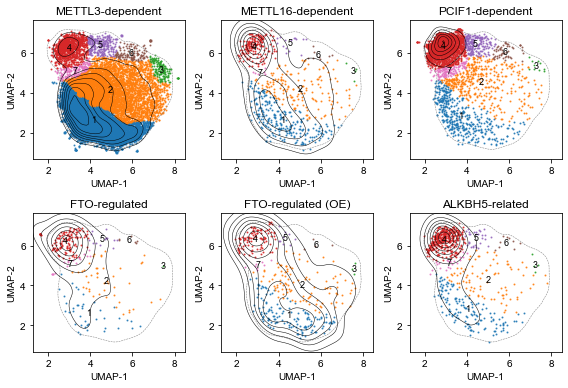

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5))

m6ACE_seq_samples = ["m6ACE-seq_METTL3", "m6ACE-seq_METTL16", "m6ACE-seq_PCIF1", "m6ACE-seq_FTO_reg", "m6ACE-seq_FTO_OE", "m6ACE-seq_ALKBH5"]

sample_titles = ["METTL3-dependent", "METTL16-dependent", "PCIF1-dependent", "FTO-regulated", "FTO-regulated (OE)", "ALKBH5-related"]
sample_names = m6ACE_seq_samples

# note: adjsut save_contour_diameter to keep the outest contour
for ax, title, samples in zip(*[axes.reshape(-1), sample_titles, sample_names]):
    draw_methods(ax, df_m6A, save_contour_diameter=5.8, s=1, alpha=0.8, title=title, target=samples, common_contour_xx=common_contour_xx, common_contour_yy=common_contour_yy, common_contour_f=common_contour_f, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
plt.tight_layout()
plt.savefig("m6ACE-seq_by_methods.pdf")

### 5.2 Analysis on m6ACE-seq data only

In [35]:
df_m6ACE = df_m6A[df_m6A[m6ACE_seq_samples].any(axis=1)==True].copy()
df_m6ACE = df_m6ACE[m6ACE_seq_samples + ["motif_F10"]] 
print(df_m6ACE.shape)

onehot_input_m6ACE = []
for idx, row in df_m6ACE.iterrows():
    onehot_input_m6ACE.append(onehot_enc(row))
onehot_input_m6ACE = np.array(onehot_input_m6ACE)

(19702, 7)


In [36]:
_, _, df_m6ACE = UMAP(onehot_input_m6ACE, df_m6ACE, verbose=True)

UMAP
UMAP(init='random', min_dist=0.01, n_neighbors=20, random_state=42, verbose=True)
Sun Feb 13 01:32:21 2022 Construct fuzzy simplicial set
Sun Feb 13 01:32:22 2022 Finding Nearest Neighbors
Sun Feb 13 01:32:22 2022 Building RP forest with 12 trees
Sun Feb 13 01:32:23 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Sun Feb 13 01:32:28 2022 Finished Nearest Neighbor Search
Sun Feb 13 01:32:28 2022 Construct embedding



Sun Feb 13 01:32:50 2022 Finished embedding
UMAP time: 28.830747604370117 sec
UMAP RAM: 117.71460247039795 MB



HDBSCAN soft clustering time: 2.975740671157837 sec
HDBSCAN soft clustering RAM: 110.77279281616211 Mb
HDBSCAN cluster number: 2
Cluster
1     5086
2    14616
Name: Cluster, dtype: int64


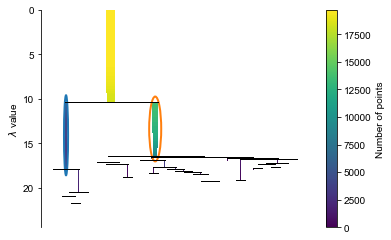

In [37]:
_, _, df_m6ACE, _= cluster_HDBSCAN_softclustering(df_m6ACE, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0)

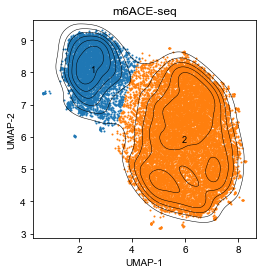

In [38]:
fig, ax = plt.subplots(figsize=(4,4))
xmin, xmax, ymin, ymax = draw_one_sample(ax, df_m6ACE, s=1, title="m6ACE-seq")
plt.savefig("m6ACE-seq.png", dpi=300)
plt.savefig("m6ACE-seq.pdf")

In [39]:
common_contour_xx, common_contour_yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([common_contour_xx.ravel(), common_contour_yy.ravel()])
values = np.vstack([df_m6ACE["X"], df_m6ACE["Y"]])
kernel = scipy.stats.gaussian_kde(values)
common_contour_f = np.reshape(kernel(positions).T, common_contour_xx.shape)

Drawing m6ACE-seq_METTL3
Drawing m6ACE-seq_METTL16
Drawing m6ACE-seq_PCIF1
Drawing m6ACE-seq_FTO_reg
Drawing m6ACE-seq_FTO_OE
Drawing m6ACE-seq_ALKBH5


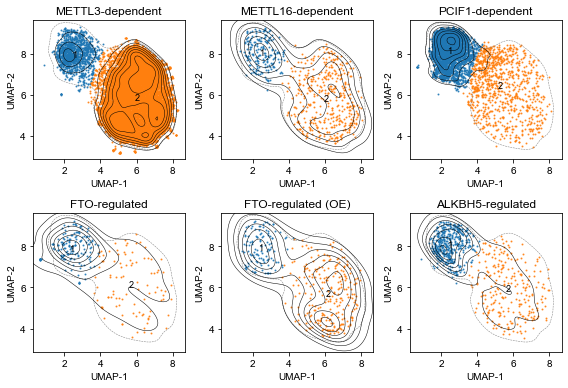

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5))

m6ACE_seq_samples = ["m6ACE-seq_METTL3", "m6ACE-seq_METTL16", "m6ACE-seq_PCIF1", "m6ACE-seq_FTO_reg", "m6ACE-seq_FTO_OE", "m6ACE-seq_ALKBH5"]

sample_titles = ["METTL3-dependent", "METTL16-dependent", "PCIF1-dependent", "FTO-regulated", "FTO-regulated (OE)", "ALKBH5-regulated"]
sample_names = m6ACE_seq_samples

# note: adjsut save_contour_diameter to keep the outest contour
for ax, title, samples in zip(*[axes.reshape(-1), sample_titles, sample_names]):
    draw_methods(ax, df_m6ACE, save_contour_diameter=5.8, s=1, alpha=0.8, title=title, target=samples, common_contour_xx=common_contour_xx, common_contour_yy=common_contour_yy, common_contour_f=common_contour_f, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
plt.tight_layout()
plt.savefig("m6ACE-seq_factors.pdf")

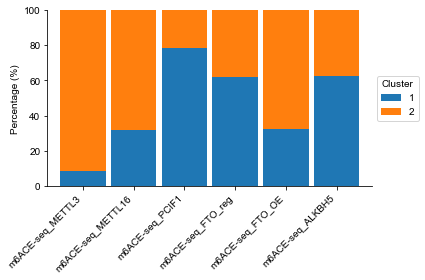

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
draw_cluster_trace(ax, df_m6ACE, "Cluster")
plt.tight_layout()
plt.savefig("Clusters_m6ACE_percentage.pdf")

In [42]:
extract_fasta_and_draw_motifs("m6ACE_seq", df_m6ACE)

===============  m6ACE_seq ===============
Cluster #1: 5086
Cluster #2: 14616


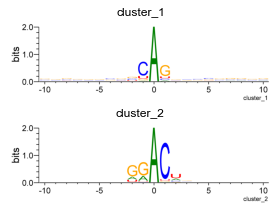

In [43]:
show_logos_cols("./m6ACE_seq/logos_bits_png/", cols=1)

In [44]:
# Let figure out the sequences inside those group

for prefix, filter in zip(*[["m6ACE_METTL3", "m6ACE_METTL16", "m6ACE_PCIF1", "m6ACE_FTO_reg", "m6ACE_FTO_OE", "m6ACE_ALKBH5"], m6ACE_seq_samples]):
    extract_fasta_and_draw_motifs(prefix, df_m6ACE, cluster_col="Cluster", filter=filter)

===============  m6ACE_METTL3 ===============
Cluster #1: 1261
Cluster #2: 13438
===============  m6ACE_METTL16 ===============
Cluster #1: 190
Cluster #2: 408
===============  m6ACE_PCIF1 ===============
Cluster #1: 3291
Cluster #2: 917
===============  m6ACE_FTO_reg ===============
Cluster #1: 156
Cluster #2: 97
===============  m6ACE_FTO_OE ===============
Cluster #1: 117
Cluster #2: 245
===============  m6ACE_ALKBH5 ===============
Cluster #1: 417
Cluster #2: 252


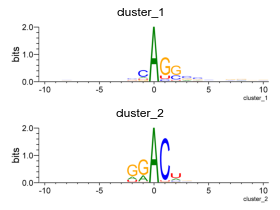

In [45]:
show_logos_cols("./m6ACE_METTL3/logos_bits_png/", cols=1)

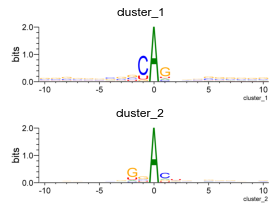

In [46]:
show_logos_cols("./m6ACE_PCIF1/logos_bits_png/", cols=1)

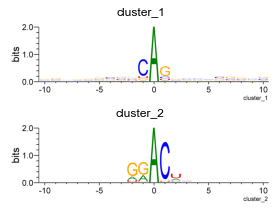

In [47]:
show_logos_cols("./m6ACE_METTL16/logos_bits_png/", cols=1)

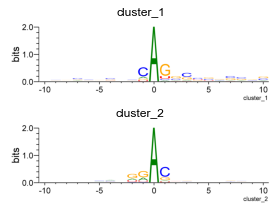

In [48]:
show_logos_cols("./m6ACE_FTO_reg/logos_bits_png/", cols=1)

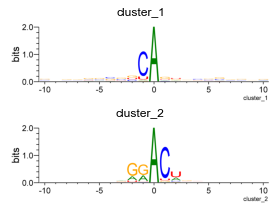

In [49]:
show_logos_cols("./m6ACE_FTO_OE/logos_bits_png/", cols=1)

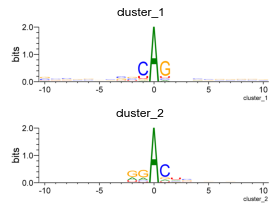

In [50]:
show_logos_cols("./m6ACE_ALKBH5/logos_bits_png/", cols=1)

## Summary

Interestingly, we found that:

1. METTLE3 not only regulate canonical m6A motifs, but also m6Am motifs (~10%)
2. ALKBH5, previously known to regulate m6A sites, also regulate a fraction of m6Am sites (~30%).

## Don't forget to save tables

In [51]:
df_m6A.to_csv("m6A_methods.clustered.csv")
df_m6ACE.to_csv("m6ACE.clustered.csv")